# Machine Learning's Capacity to Beat the Market -- Notebook
## Authors: Nathan Dejesus, Brandon Barker, Jack Lea, Mike Damiano, Ryan Schreck
---
The following notebook contains implemented machine learning algorithms to predict the [INSERT PREDICTION TARGET] for the [New York Stock Exchange dataset](https://www.kaggle.com/datasets/dgawlik/nyse/data?select=fundamentals.csv). The makeup consists of **Preprocessing**, **Implementations**, and **Analysis** concerning the data's features. 

In [2]:
######PREPROCESSING######
import pandas as pd

# Load the datasets
fundamentals = pd.read_csv('data/fundamentals.csv')
prices = pd.read_csv('data/prices.csv')
prices_split_adjusted = pd.read_csv('data/prices-split-adjusted.csv')
securities = pd.read_csv('data/securities.csv')

# Display a few rows of each dataset to check the data
fundamentals_preview = fundamentals.head()
prices_preview = prices.head()
prices_split_adjusted_preview = prices_split_adjusted.head()
securities_preview = securities.head()

#print(fundamentals_preview, prices_preview, prices_split_adjusted_preview, securities_preview)

In [3]:
# Convert date columns to datetime format for easier alignment and filtering
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'], errors='coerce')
prices['date'] = pd.to_datetime(prices['date'], errors='coerce')
prices_split_adjusted['date'] = pd.to_datetime(prices_split_adjusted['date'], errors='coerce')

# Ensure the company symbols match across datasets
common_symbols = set(fundamentals['Ticker Symbol']).intersection(set(prices['symbol']))

# Filter the datasets for common symbols only
fundamentals_filtered = fundamentals[fundamentals['Ticker Symbol'].isin(common_symbols)]
prices_filtered = prices[prices['symbol'].isin(common_symbols)]
prices_split_adjusted_filtered = prices_split_adjusted[prices_split_adjusted['symbol'].isin(common_symbols)]

# Remove rows with NaT values in the date columns to avoid the 'NaTType' normalization error
fundamentals_filtered = fundamentals_filtered.dropna(subset=['Period Ending'])
prices_filtered = prices_filtered.dropna(subset=['date'])

# Preview the filtered datasets to confirm alignment based on common symbols
fundamentals_filtered_preview = fundamentals_filtered.head()
prices_filtered_preview = prices_filtered.head()
prices_split_adjusted_filtered_preview = prices_split_adjusted_filtered.head()

#print(fundamentals_filtered_preview, prices_filtered_preview, prices_split_adjusted_filtered_preview)

In [4]:
# Resample the prices data to a quarterly basis
prices_quarterly = prices_filtered.set_index('date').groupby('symbol').resample('QE').agg({
    'open': 'mean',
    'close': 'mean',
    'low': 'mean',
    'high': 'mean',
    'volume': 'sum'
}).reset_index()

# Display the resampled quarterly prices data
#print(prices_quarterly.head())

  symbol       date       open      close        low       high       volume
0    AIV 2010-03-31  16.804098  16.851639  16.583771  17.058033  134857400.0
1    AIV 2010-06-30  20.923492  20.970159  20.483175  21.419524  163720200.0
2    AIV 2010-09-30  21.003125  21.032656  20.679531  21.325469  123155600.0
3    AIV 2010-12-31  24.053594  24.103437  23.813281  24.363281   92661700.0
4    AIV 2011-03-31  24.751452  24.735484  24.442581  25.006613   77272700.0


In [5]:
# Align fundamentals with prices data based on company symbols and nearest corresponding quarters
# Merge fundamentals and quarterly prices data on 'Ticker Symbol' and 'symbol' (company symbols) and the nearest quarter end dates

# Renaming 'Ticker Symbol' in fundamentals to match 'symbol' for merging
fundamentals_filtered = fundamentals_filtered.rename(columns={'Ticker Symbol': 'symbol'})

# Merging with nearest join on date within the same quarter period
aligned_data = pd.merge_asof(prices_quarterly.sort_values('date'), 
                             fundamentals_filtered.sort_values('Period Ending'), 
                             by='symbol', 
                             left_on='date', 
                             right_on='Period Ending', 
                             direction='backward')

# Display a preview of the aligned dataset
#print(aligned_data.head())


In [17]:
# Dropping rows with missing values in essential columns (e.g., financial metrics and prices)
essential_columns = ['open', 'close', 'low', 'high', 'volume', 'Accounts Payable', 
                     'Accounts Receivable', 'Total Revenue', 'Earnings Per Share']
aligned_data_cleaned = aligned_data.dropna(subset=essential_columns)

# Display a preview of the cleaned dataset
#print(aligned_data_cleaned.head())

C:\Users\barke\AppData\Local\Temp\ipykernel_17436\142732511.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aligned_data_cleaned['Cash Ratio'].fillna(aligned_data_cleaned['Cash Ratio'].median(), inplace=True)
C:\Users\barke\AppData\Local\Temp\ipykernel_17436\142732511.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aligned_data_cleaned

                                date       open      close        low  \
count                             17  17.000000  17.000000  17.000000   
mean   2014-12-30 09:52:56.470588160  34.801879  34.827166  34.497163   
min              2012-12-31 00:00:00  25.738710  25.733387  25.513387   
25%              2013-12-31 00:00:00  29.183750  29.146562  28.873750   
50%              2014-12-31 00:00:00  35.669531  35.736562  35.421094   
75%              2015-12-31 00:00:00  38.557656  38.636250  38.252031   
max              2016-12-31 00:00:00  45.154531  45.177344  44.745937   
std                              NaN   5.929448   5.938137   5.858972   

            high        volume  Unnamed: 0                  Period Ending  \
count  17.000000  1.700000e+01   17.000000                             17   
mean   35.116023  7.853039e+07   61.588235  2014-08-02 16:56:28.235294208   
min    25.921936  5.881850e+07   60.000000            2012-12-31 00:00:00   
25%    29.442656  7.200150e+07   6

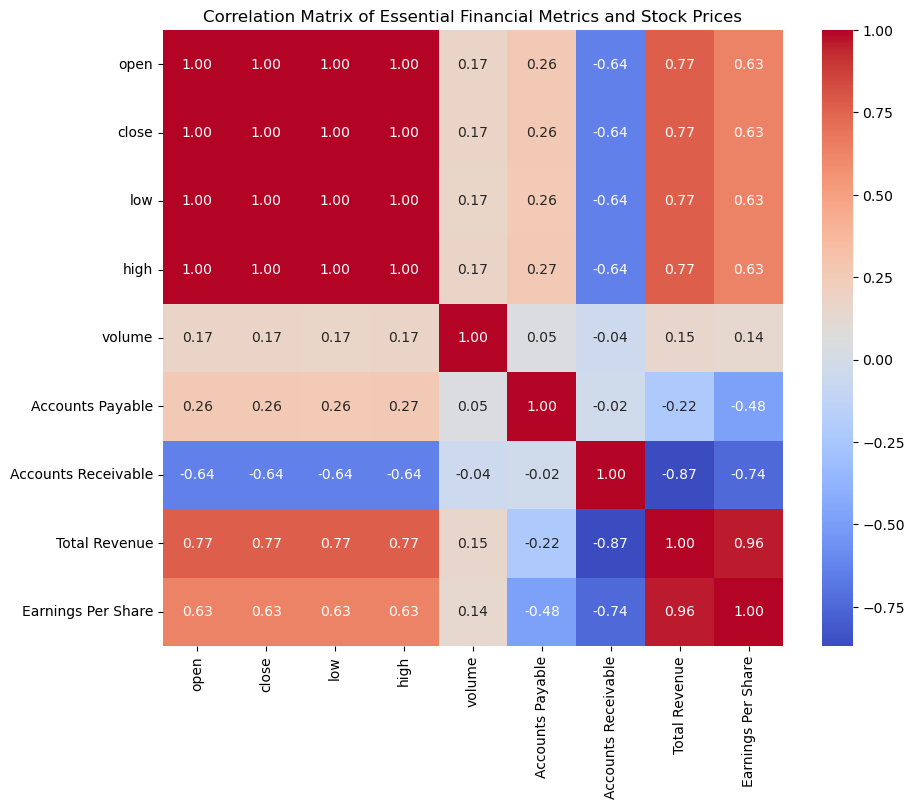

In [21]:
##Visualization##
import matplotlib.pyplot as plt
import seaborn as sns

# Display descriptive statistics for the cleaned dataset
desc_stats = aligned_data_cleaned.describe()
print(desc_stats)

# Calculate correlations for key financial metrics and stock prices
correlation_matrix = aligned_data_cleaned[essential_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices")
plt.show()

In [39]:
##Feature Selection##

# Identifying non-numeric columns in the dataset
non_numeric_columns = aligned_data_cleaned.select_dtypes(exclude=['float64', 'int64']).columns

# Dropping non-numeric columns and recalculating correlations with 'close'
aligned_data_numeric = aligned_data_cleaned.drop(columns=non_numeric_columns)
all_feature_correlations = aligned_data_numeric.corr()['close'].sort_values(ascending=False)

# Display the correlations again without the non-numeric columns
pd.set_option('display.max_rows', None)
print(all_feature_correlations)


close                                                  1.000000
open                                                   0.999976
low                                                    0.999968
high                                                   0.999950
Retained Earnings                                      0.922376
Pre-Tax Margin                                         0.919399
For Year                                               0.905816
Unnamed: 0                                             0.905816
Total Equity                                           0.897873
Misc. Stocks                                           0.896918
Sale and Purchase of Stock                             0.879788
Net Income-Cont. Operations                            0.869493
Gross Profit                                           0.859027
Fixed Assets                                           0.852564
Pre-Tax ROE                                            0.851687
Net Cash Flows-Financing                

In [41]:
#I am choosing to select all features with correlation between .6 and .9. We could raise this bar if we want
# Selecting the specified features from the aligned dataset
selected_features = [
    'Total Equity', 'Misc. Stocks', 'Sale and Purchase of Stock', 'Net Income-Cont. Operations',
    'Gross Profit', 'Fixed Assets', 'Pre-Tax ROE', 'Net Cash Flows-Financing', 'Earnings Before Tax',
    'Gross Margin', 'Total Revenue', 'Common Stocks', 'Net Cash Flow-Operating', 'Net Income', 
    'Capital Surplus', 'Profit Margin', 'Net Income Applicable to Common Shareholders', 'Liabilities', 
    'Operating Income', 'Other Financing Activities', 'Earnings Per Share', 'Operating Margin'
]

# Filter the dataset to include only the selected features along with the target variable 'close'
selected_data = aligned_data_cleaned[selected_features + ['close']]

print(selected_data.head())

    Total Equity  Misc. Stocks  Sale and Purchase of Stock  \
11   915425000.0    80046000.0                 -14660000.0   
12   915425000.0    80046000.0                 -14660000.0   
13   915425000.0    80046000.0                 -14660000.0   
14   915425000.0    80046000.0                 -14660000.0   
15   967457000.0    79953000.0                 -15782000.0   

    Net Income-Cont. Operations  Gross Profit  Fixed Assets  Pre-Tax ROE  \
11                  -18756000.0   572156000.0  5.234961e+09          2.0   
12                  -18756000.0   572156000.0  5.234961e+09          2.0   
13                  -18756000.0   572156000.0  5.234961e+09          2.0   
14                  -18756000.0   572156000.0  5.234961e+09          2.0   
15                   34596000.0   594002000.0  5.391209e+09          3.0   

    Net Cash Flows-Financing  Earnings Before Tax  Gross Margin  ...  \
11              -435147000.0          -19614000.0          60.0  ...   
12              -435147000